In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

## Полиномиальная регрессия и оверфиттинг

In [4]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для 
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)


[ 1.09078579 -0.01723828 -0.36474644]
[  2.16379668   4.41542108 -15.7716727  -25.60120287  74.12281026
  12.58236417 -82.09399606  17.98760401  23.14633046  -8.40972924]


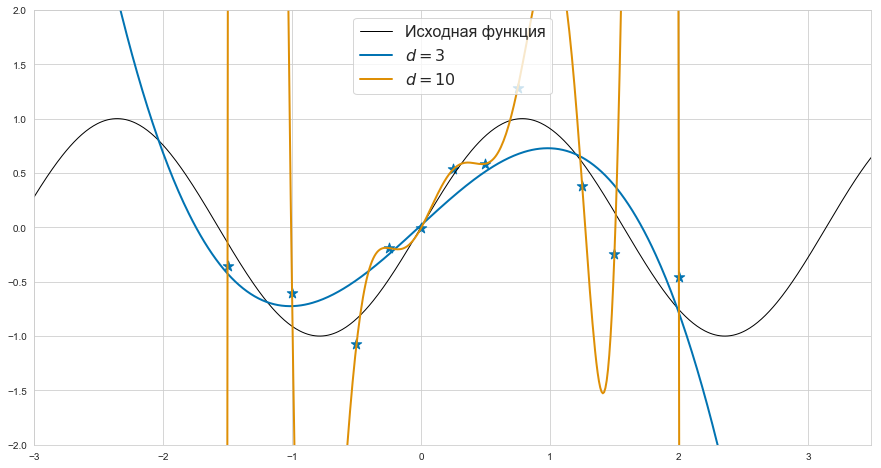

In [5]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 3, 10 ]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

## Локальные признаки в линейной регрессии

Коэффициенты с 10 признаками: -12.7719 -10.7627 -13.4100 -11.1301 -10.9637 -10.6476 -9.7823 -10.5408 -11.5686 -12.7610


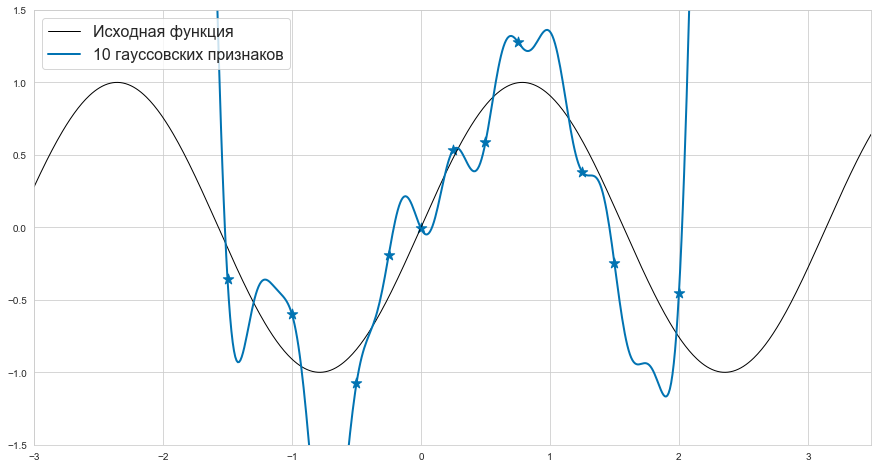

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

nums_gauss = [10, ]
gauss_xd, gauss_yd = xd, data

class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, N, width_factor=.5):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-1.5, 1.5))
ax.scatter(gauss_xd, gauss_yd, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for num_gauss in nums_gauss:
    gauss_model = make_pipeline(GaussianFeatures(num_gauss),
                                linear_model.LinearRegression())
    gauss_model.fit(xd[:, np.newaxis], data)
    yfit = gauss_model.predict(xs[:, np.newaxis])
    print("Коэффициенты с %d признаками: %s" % (num_gauss, " ".join(["%.4f" % x for x in gauss_model.get_params()['linearregression'].coef_])))
    ax.plot(xs, yfit, linewidth=2, label="%d гауссовских признак%s" % (num_gauss, "а" if num_gauss < 5 else "ов") )

ax.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

In [7]:
num_gauss = 5
gauss_model = make_pipeline(GaussianFeatures(num_gauss), linear_model.LinearRegression())
gauss_model.fit(gauss_xd[:, np.newaxis], gauss_yd)
yfit = gauss_model.predict(xs[:, np.newaxis])
mfeat = gauss_model.get_params()['gaussianfeatures']
mregr = gauss_model.get_params()['linearregression']
print("Коэффициенты с %d признаками: %s" % (num_gauss, " ".join(["%.4f" % x for x in gauss_model.get_params()['linearregression'].coef_])))
print("Свободный член: %.4f" % mregr.intercept_)

Коэффициенты с 5 признаками: -9.3916 -9.1998 -7.8295 -7.4412 -10.0020
Свободный член: 10.4459


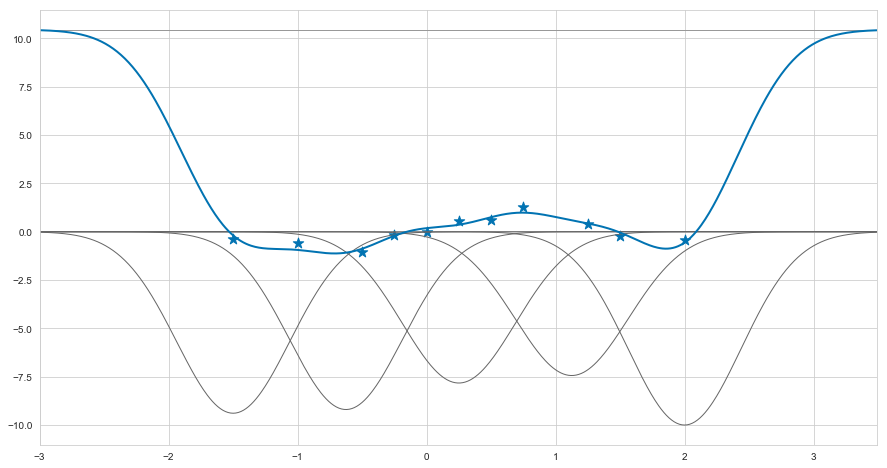

In [8]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
# ax.set_ylim((-1.5, 1.5))
ax.scatter(gauss_xd, gauss_yd, marker='*', s=120)
# ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for i in range(mfeat.N):
    cur_yfit = [mregr.coef_[i] * mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.4", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, linewidth=2)

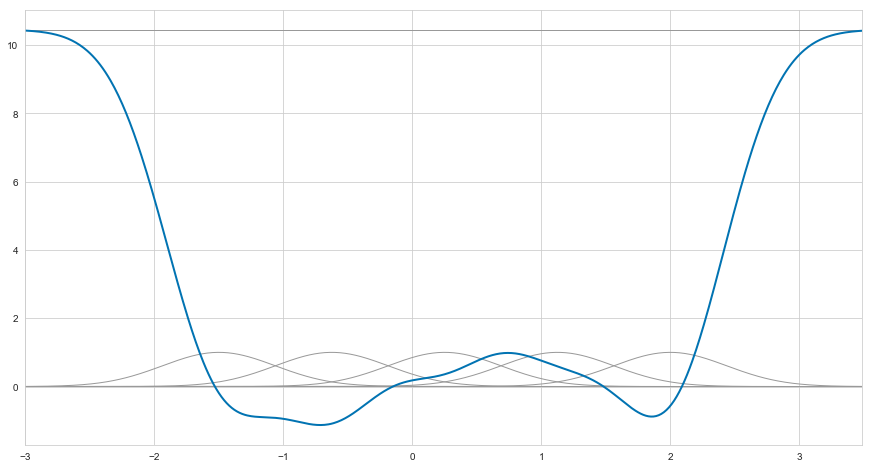

In [9]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))

for i in range(mfeat.N):
    cur_yfit = [mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.6", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, linewidth=2)

NameError: name 'xd_large' is not defined

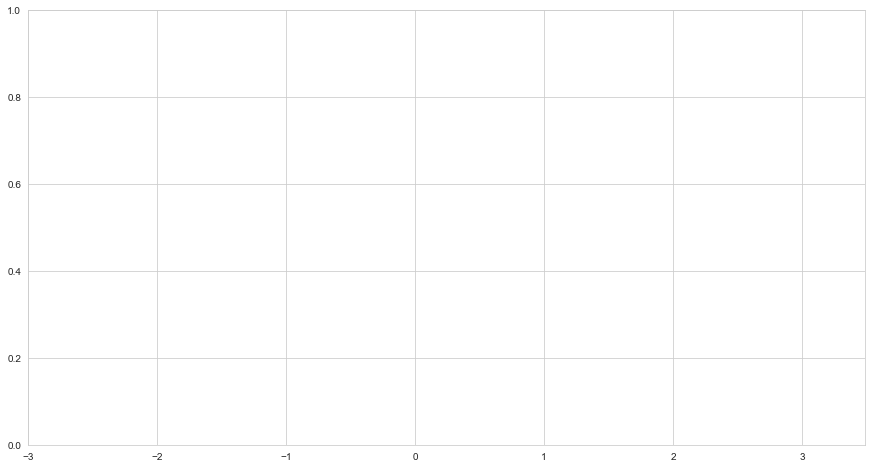

In [10]:
num_gauss=25

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
# ax.set_ylim((-1.5, 1.5))
ax.scatter(xd_large, data_large, marker='*', s=120)
# ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

gauss_model = make_pipeline(GaussianFeatures(num_gauss), linear_model.LinearRegression())
gauss_model.fit(gauss_xd[:, np.newaxis], gauss_yd)
yfit = gauss_model.predict(xs[:, np.newaxis])
mfeat = gauss_model.get_params()['gaussianfeatures']
mregr = gauss_model.get_params()['linearregression']

for i in range(mfeat.N):
    cur_yfit = [mregr.coef_[i] * mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.4", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, linewidth=2)

## Добавим ещё данных

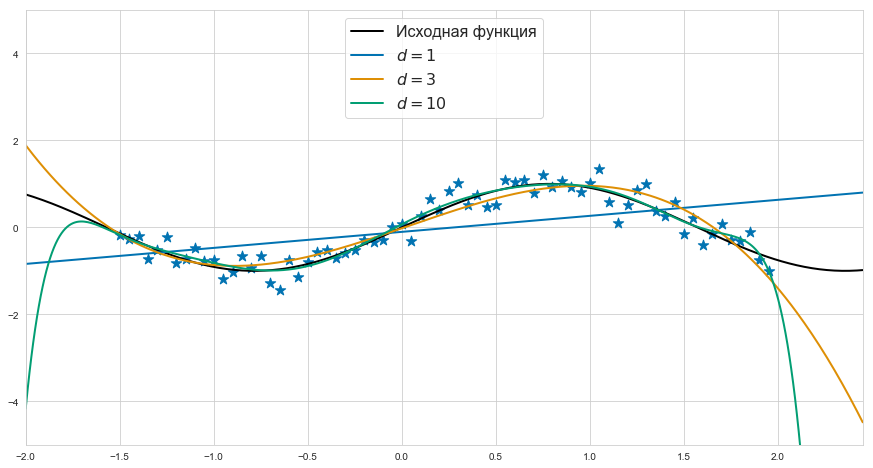

In [11]:
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd_large = np.arange(-1.5, 2, 0.05)
num_points_l = len(xd_large)

## Данные
data_large = orig(xd_large) + np.random.normal(0, .25, num_points_l)

## Для 
xs = np.arange(xd_large[0]-.5, xd_large[-1]+.5, 0.01)

## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d_large = np.vstack([xd_large ** i for i in range(1, num_points+1)]).transpose()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-5, 5))
ax.scatter(xd_large, data_large, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color="black")

set_of_powers = [ 1, 3, 10 ]

for d in set_of_powers:
    cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d_large[:, :d], data_large )
    ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper center", fontsize=legend_fontsize)

plt.show()

## Регуляризация

Коэффициенты для alpha=10.100000:
[ 0.19539505  0.00746227  0.08944663 -0.01002966  0.04235924 -0.03262775
  0.0017205  -0.04893332 -0.02207843  0.02226681]


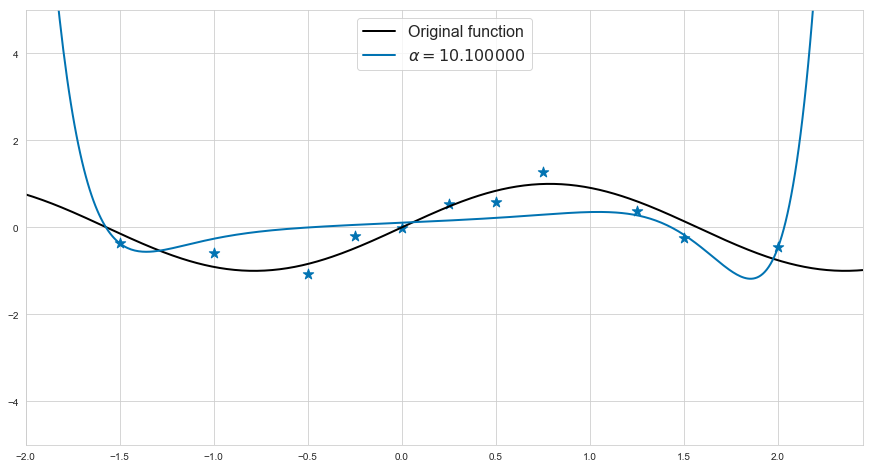

In [12]:
alpha_values = [ 10.1,  ]
use_lasso = False

@ignore_warnings(category=ConvergenceWarning)
def train_model(xs, ys, alpha, use_lasso):
    if alpha == 0:
        return linear_model.LinearRegression(fit_intercept=True).fit( xs, ys )
    else:
        if use_lasso:
            return linear_model.Lasso(alpha=alpha, fit_intercept=True).fit( xs, ys )
        else:
            return linear_model.Ridge(alpha=alpha, fit_intercept=True).fit( xs, ys )

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-5, 5))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=2, label="Original function", color="black")

for alpha in alpha_values:
    m = train_model(xd_d[:, :10], data, alpha, use_lasso)
    print ("Коэффициенты для alpha=%f:\n%s" % (alpha, m.coef_))
    ax.plot(xs, m.predict( xs_d[:, :10] ), linewidth=2, label="$\\alpha=%f$" % alpha)

ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

## Усреднение

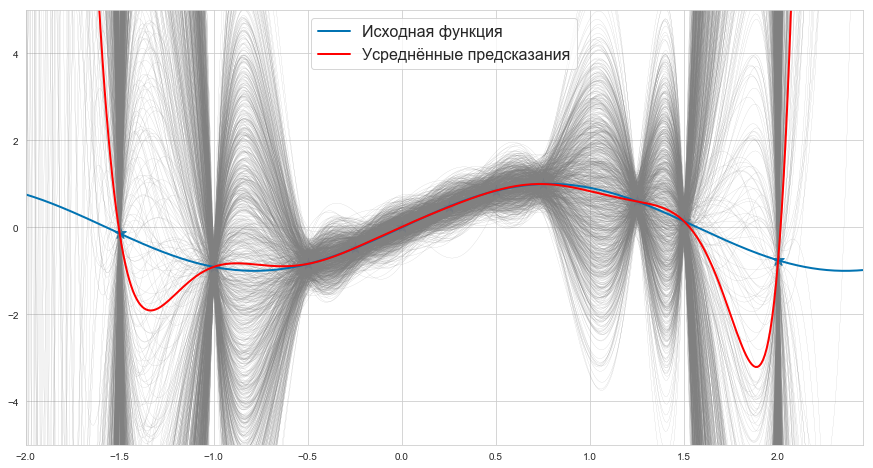

In [13]:
N = 1000
alpha = 0.
use_lasso = True

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-5, 5))

res = []
for _ in range(N):
    cur_data = orig(xd) + np.random.normal(0, .25, num_points)
    cur_model = train_model(xd_d, cur_data, alpha, use_lasso)
    res.append(cur_model.predict( xs_d ))
    ax.plot(xs, res[-1], linewidth=.1, color="0.5")

ax.plot(xs, orig(xs), linewidth=2, label="Исходная функция", color=palette[0])
ax.scatter(xd, orig(xd), marker='*', s=150, color=palette[0])

ax.plot(xs, np.mean( res, axis=0 ), linewidth=2, label="Усреднённые предсказания", color="red")
ax.legend(loc="upper center", fontsize=legend_fontsize)
plt.show()

# Байесовский вывод в линейной регрессии

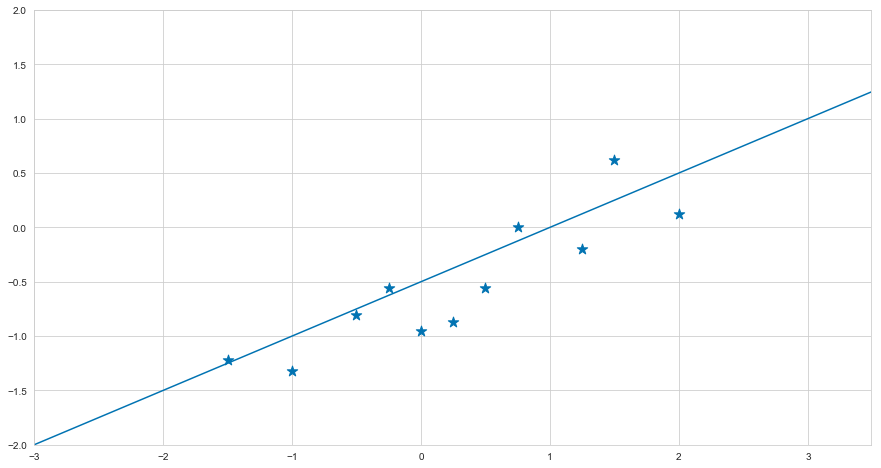

In [14]:
## Исходная функция
orig = lambda x : .5*x - .5

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## Для рисования
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.plot(xs, orig(xs))
ax.scatter(xd, data, marker='*', s=120)
plt.show()

In [23]:
from scipy.stats import multivariate_normal

# create data
N = 250
xs = np.linspace(-3, 3, N)
X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def myplot_heatmap(Z):
    # Make the plot
    plt.axis('equal')
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter([-.5], [.5], marker='*', s=120)
    plt.show()

(250, 250)


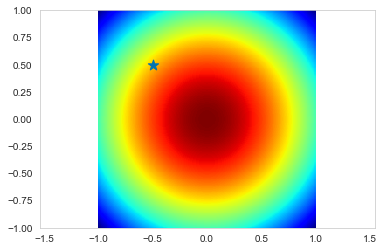

In [24]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

myplot_heatmap(Z)

In [25]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)

    # plt.axis('equal')
    for w in my_w:
        plt.plot(xs, w[0] + w[1]*xs, 'k-', lw=.4)
    plt.ylim((-3, 3))
    plt.xlim((-3, 3))
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.show()

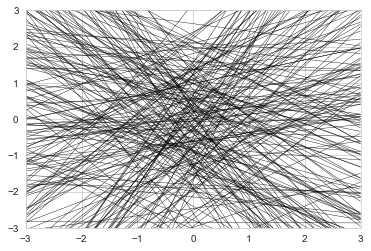

In [26]:
myplot_sample_lines(cur_mu, cur_sigma, 200)

0.25 -0.8733101651753878


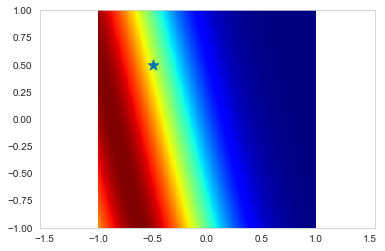

In [27]:
def get_likelihood(px, py):
    return lambda x : np.exp(-2*(x[0] + x[1]*px - py) ** 2) / (.25 * np.sqrt(2.*np.pi))

print(xd[5], data[5])
px, py = xd[5], data[5]
cur_likelihood = get_likelihood(px, py)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])

myplot_heatmap(Z)

In [28]:
def bayesian_update(mu, sigma, x, y):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (.25 ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (.25 ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

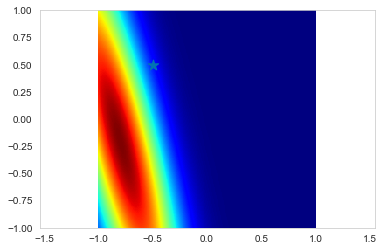

In [29]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)

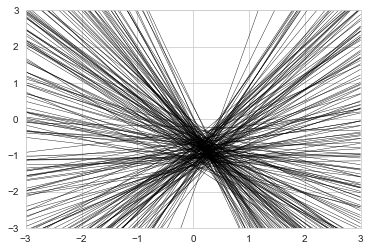

In [30]:
# Посэмплируем и порисуем прямые
myplot_sample_lines(cur_mu, cur_sigma, 200, points=[[px], [py]])

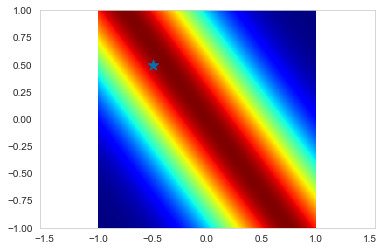

In [31]:
px2, py2 = xd[7], data[7]
cur_likelihood = get_likelihood(px2, py2)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
myplot_heatmap(Z)

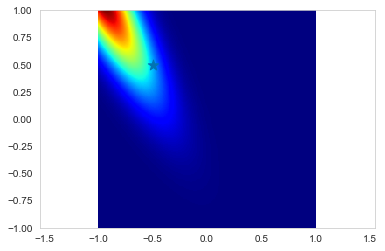

In [32]:
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px2, py2)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)

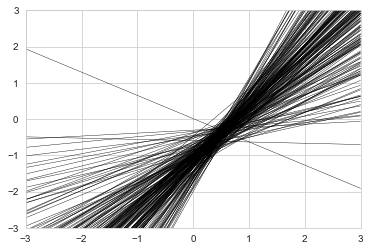

In [33]:
myplot_sample_lines(cur_mu, cur_sigma, n=200, points=[[px, px2], [py, py2]])

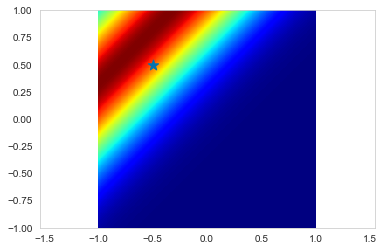

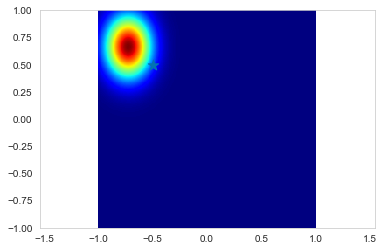

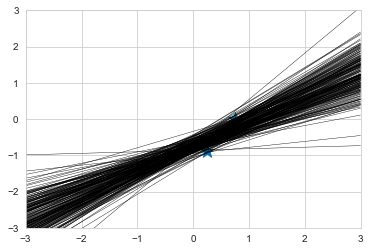

In [34]:
px3, py3 = xd[1], data[1]
cur_likelihood = get_likelihood(px3, py3)
Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
myplot_heatmap(Z)
cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px3, py3)
Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
myplot_heatmap(Z)
myplot_sample_lines(cur_mu, cur_sigma, n=200, points=[[px, px2, px3], [py, py2, py3]])